# Modeling and Results

In [1]:
!pip install pycountry_convert
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry_convert as pc
from sklearn.linear_model import Lasso, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from textwrap import wrap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, KFold, GridSearchCV
from xgboost import XGBRegressor
from project_utilities import *

## LASSO

In [2]:
# read in the data
fifa_15 = pd.read_csv('data/players_15.csv')
fifa_16 = pd.read_csv('data/players_16.csv')
fifa_17 = pd.read_csv('data/players_17.csv')
fifa_18 = pd.read_csv('data/players_18.csv')
fifa_19 = pd.read_csv('data/players_19.csv')
fifa_20 = pd.read_csv('data/players_20.csv')
fifa_21 = pd.read_csv('data/players_21.csv')

player_lookup_map = {game_id: name for (game_id, name) in zip(fifa_15.sofifa_id, fifa_15.long_name)}

In [3]:
# a key problem faced is that with a 6 year gap, a lot of the players are not still around
# with 16k players in 2015, only 5700 of those are still around in 2021
# this limits the size of training set we have available on a 6 year horizon

In [4]:
# focus just on 2015-2021 for now

# fit a regression model on the 2015 data excluding the 2015 value to predict the relative percent difference in value
# use MAE as the performance metric

# 4923 observations
x_scaled_15_21, y_15_21, col_names = horizon_data_prep(fifa_15, fifa_21, False)
# train test split 80/20
X_train, X_test, y_train, y_test = train_test_split(x_scaled_15_21, y_15_21, test_size=0.2, random_state=42)

In [5]:
lasso_6 = LassoCV(max_iter = 10000, random_state = 42).fit(X_train.drop(['sofifa_id'], axis = 1), y_train)


In [6]:
# training R^2 is only 19% - pretty bad (could be because of 6 year horizon)
lasso_6.score(X_train.drop(['sofifa_id'], axis = 1), y_train)

0.17460898314910234

In [7]:
print("The optimal alpha value is: {}".format(lasso_6.alpha_))
print("There are {} predictors after LASSO".format(sum(np.around(lasso_6.coef_, 2) != 0)))
top_10_coef_idx = np.argsort([abs(i) for i in lasso_6.coef_])[-10:]

The optimal alpha value is: 0.14194870533037712
There are 40 predictors after LASSO


In [8]:
# predict on test set
preds = lasso_6.predict(X_test.drop(['sofifa_id'], axis = 1))
lasso_training_mae = mean_absolute_error(y_test, preds)
print("average player value percent change: {}".format(round(np.mean(y_15_21), 2)))
print("LASSO Training MAE: {}".format(round(lasso_training_mae, 2)))

average player value percent change: 9.09
LASSO Training MAE: 12.03


In [9]:
# top potential players in test set predicted
top_10_preds = np.argsort(preds)[::-1][:10]

top_10_ids = X_test.iloc[top_10_preds, :]['sofifa_id'].values
print('predicted top 10 highest growth players 2015-2021')
pred_best = set([player_lookup_map[i] for i in top_10_ids])
pred_best

predicted top 10 highest growth players 2015-2021


{'Aaron Collins',
 'Andy Cannon',
 'David Philani Moyo',
 'Dominic Calvert-Lewin',
 'Jens Jakob Thomasen',
 'Justen Glad',
 'Marco Komenda',
 'Matthew Palmer',
 'Maximilian Reinthaler',
 'Sebastiano Luperto'}

In [10]:
# top 10 actual highest potential players

In [11]:
top_10_actual = np.argsort(y_test)[::-1][:10]

top_10_ids = X_test.iloc[top_10_actual, :]['sofifa_id'].values
print('Actual top 10 highest growth players 2015-2021')
actual_best = set([player_lookup_map[i] for i in top_10_ids])
actual_best

Actual top 10 highest growth players 2015-2021


{'Bamidele Alli',
 'Clément Nicolas Laurent Lenglet',
 'Dominic Calvert-Lewin',
 'Joseph Gomez',
 'Konrad Laimer',
 'Leroy Sané',
 'Luis Jesús Rioja González',
 'Nico Elvedi',
 'Philipp Max',
 'Renato Steffen'}

In [12]:
# our model was able to predict 2 out of the 10 highest growth players from 2015 to 2021
# with the top 100 highest growth players, the model was able to identify 40% of them on a 6 year horizon
len(pred_best.intersection(actual_best))

1

### predict value change on 1 year horizon

In [13]:
# 4923 observations
x_scaled_15_16, y_15_16, col_names = horizon_data_prep(fifa_15, fifa_16, False)
# train test split 80/20
X_train, X_test, y_train, y_test = train_test_split(x_scaled_15_16, y_15_16, test_size=0.2, random_state=42)

In [14]:
lasso_1 = LassoCV(max_iter = 10000, random_state = 42).fit(X_train.drop(['sofifa_id'], axis = 1), y_train)


In [15]:
# training R^2 is only 19% - pretty bad (could be because of 6 year horizon)
lasso_1.score(X_train.drop(['sofifa_id'], axis = 1), y_train)

0.17434667544512017

In [16]:
print("The optimal alpha value is: {}".format(lasso_1.alpha_))
print("There are {} predictors after LASSO".format(sum(np.around(lasso_1.coef_, 2) != 0)))
top_10_coef_idx = np.argsort([abs(i) for i in lasso_1.coef_])[-10:]

The optimal alpha value is: 0.013677511396553538
There are 38 predictors after LASSO


In [17]:
# predict on test set
preds = lasso_1.predict(X_test.drop(['sofifa_id'], axis = 1))
lasso_training_mae = mean_absolute_error(y_test, preds)
print("average player value percent change: {}".format(round(np.mean(y_15_21), 2)))
print("LASSO Training MAE: {}".format(round(lasso_training_mae, 2)))

average player value percent change: 9.09
LASSO Training MAE: 1.23


In [18]:
# top potential players in test set predicted
top_10_preds = np.argsort(preds)[::-1][:100]

top_10_ids = X_test.iloc[top_10_preds, :]['sofifa_id'].values
print('predicted top 10 highest growth players 2015-2021')
pred_best = set([player_lookup_map[i] for i in top_10_ids])
#pred_best

predicted top 10 highest growth players 2015-2021


In [19]:
# top 10 actual highest potential players

In [20]:
top_10_actual = np.argsort(y_test)[::-1][:100]

top_10_ids = X_test.iloc[top_10_actual, :]['sofifa_id'].values
print('Actual top 10 highest growth players 2015-2021')
actual_best = set([player_lookup_map[i] for i in top_10_ids])
#actual_best

Actual top 10 highest growth players 2015-2021


In [21]:
# our model was able to predict 2 out of the 10 highest growth players from 2015 to 2021
# with the top 100 highest growth players, the model was able to identify 26% of the them in the 1 year horizon 2015 to 2016
print("Model Percent Correct Identification of top 100 players: {}%".format(len(pred_best.intersection(actual_best))))

Model Percent Correct Identification of top 100 players: 20%


In [22]:
# the 1 year horizon model was only able to pick up on 1 of the actual 10 best high potential players

### predict value change on 2 year horizon

In [23]:
# 4923 observations
x_scaled_15_17, y_15_17, col_names = horizon_data_prep(fifa_15, fifa_17, False)
# train test split 80/20
X_train, X_test, y_train, y_test = train_test_split(x_scaled_15_17, y_15_17, test_size=0.2, random_state=42)

In [24]:
lasso_2 = LassoCV(max_iter = 10000, random_state = 42).fit(X_train.drop(['sofifa_id'], axis = 1), y_train)


In [25]:
# training R^2 is only 19% - pretty bad (could be because of 6 year horizon)
lasso_2.score(X_train.drop(['sofifa_id'], axis = 1), y_train)

0.14677030732114393

In [26]:
print("The optimal alpha value is: {}".format(lasso_2.alpha_))
print("There are {} predictors after LASSO".format(sum(np.around(lasso_2.coef_, 2) != 0)))
top_10_coef_idx = np.argsort([abs(i) for i in lasso_2.coef_])[-10:]

The optimal alpha value is: 0.036173362572732126
There are 40 predictors after LASSO


In [27]:
# predict on test set
preds = lasso_2.predict(X_test.drop(['sofifa_id'], axis = 1))
lasso_training_mae = mean_absolute_error(y_test, preds)
print("average player value percent change: {}".format(round(np.mean(y_15_21), 2)))
print("LASSO Training MAE: {}".format(round(lasso_training_mae, 2)))

average player value percent change: 9.09
LASSO Training MAE: 3.07


In [28]:
# top potential players in test set predicted
top_10_preds = np.argsort(preds)[::-1][:100]

top_10_ids = X_test.iloc[top_10_preds, :]['sofifa_id'].values
print('predicted top 10 highest growth players 2015-2021')
pred_best = set([player_lookup_map[i] for i in top_10_ids])
#pred_best

predicted top 10 highest growth players 2015-2021


In [29]:
# top 10 actual highest potential players

In [30]:
top_10_actual = np.argsort(y_test)[::-1][:100]

top_10_ids = X_test.iloc[top_10_actual, :]['sofifa_id'].values
print('Actual top 10 highest growth players 2015-2021')
actual_best = set([player_lookup_map[i] for i in top_10_ids])
#actual_best

Actual top 10 highest growth players 2015-2021


In [31]:
# our model was able to predict 2 out of the 10 highest growth players from 2015 to 2021
# with the top 100 highest growth players, the model was able to identify 26% of the them in the 1 year horizon 2015 to 2016
print("Model Percent Correct Identification of top 100 players: {}%".format(len(pred_best.intersection(actual_best))))

Model Percent Correct Identification of top 100 players: 36%


### predict value change on 3 year horizon

In [32]:
# 4923 observations
x_scaled_15_18, y_15_18, col_names = horizon_data_prep(fifa_15, fifa_18, False)
# train test split 80/20
X_train, X_test, y_train, y_test = train_test_split(x_scaled_15_18, y_15_18, test_size=0.2, random_state=42)

In [33]:
lasso_3 = LassoCV(max_iter = 10000, random_state = 42).fit(X_train.drop(['sofifa_id'], axis = 1), y_train)


In [34]:
# training R^2 is only 19% - pretty bad (could be because of 6 year horizon)
lasso_3.score(X_train.drop(['sofifa_id'], axis = 1), y_train)

0.11475873309353435

In [35]:
print("The optimal alpha value is: {}".format(lasso_3.alpha_))
print("There are {} predictors after LASSO".format(sum(np.around(lasso_3.coef_, 2) != 0)))
top_10_coef_idx = np.argsort([abs(i) for i in lasso_3.coef_])[-10:]

The optimal alpha value is: 0.11221275106931444
There are 31 predictors after LASSO


In [36]:
# predict on test set
preds = lasso_3.predict(X_test.drop(['sofifa_id'], axis = 1))
lasso_training_mae = mean_absolute_error(y_test, preds)
print("average player value percent change: {}".format(round(np.mean(y_15_21), 2)))
print("LASSO Training MAE: {}".format(round(lasso_training_mae, 2)))

average player value percent change: 9.09
LASSO Training MAE: 5.57


In [37]:
# top potential players in test set predicted
top_10_preds = np.argsort(preds)[::-1][:100]

top_10_ids = X_test.iloc[top_10_preds, :]['sofifa_id'].values
print('predicted top 10 highest growth players 2015-2021')
pred_best = set([player_lookup_map[i] for i in top_10_ids])
#pred_best

predicted top 10 highest growth players 2015-2021


In [38]:
# top 10 actual highest potential players

In [39]:
top_10_actual = np.argsort(y_test)[::-1][:100]

top_10_ids = X_test.iloc[top_10_actual, :]['sofifa_id'].values
print('Actual top 10 highest growth players 2015-2021')
actual_best = set([player_lookup_map[i] for i in top_10_ids])
#actual_best

Actual top 10 highest growth players 2015-2021


In [40]:
# our model was able to predict 2 out of the 10 highest growth players from 2015 to 2021
# with the top 100 highest growth players, the model was able to identify 26% of the them in the 1 year horizon 2015 to 2016
print("Model Percent Correct Identification of top 100 players: {}%".format(len(pred_best.intersection(actual_best))))

Model Percent Correct Identification of top 100 players: 29%


### predict value change on 4 year horizon

In [41]:
# 4923 observations
x_scaled_15_19, y_15_19, col_names = horizon_data_prep(fifa_15, fifa_19, False)
# train test split 80/20
X_train, X_test, y_train, y_test = train_test_split(x_scaled_15_19, y_15_19, test_size=0.2, random_state=42)

In [42]:
lasso_4 = LassoCV(max_iter = 10000, random_state = 42).fit(X_train.drop(['sofifa_id'], axis = 1), y_train)


In [43]:
# training R^2 is only 19% - pretty bad (could be because of 6 year horizon)
lasso_4.score(X_train.drop(['sofifa_id'], axis = 1), y_train)

0.12792075130389413

In [44]:
print("The optimal alpha value is: {}".format(lasso_4.alpha_))
print("There are {} predictors after LASSO".format(sum(np.around(lasso_4.coef_, 2) != 0)))
top_10_coef_idx = np.argsort([abs(i) for i in lasso_4.coef_])[-10:]

The optimal alpha value is: 0.09643808677983894
There are 44 predictors after LASSO


In [45]:
# predict on test set
preds = lasso_4.predict(X_test.drop(['sofifa_id'], axis = 1))
lasso_training_mae = mean_absolute_error(y_test, preds)
print("average player value percent change: {}".format(round(np.mean(y_15_21), 2)))
print("LASSO Training MAE: {}".format(round(lasso_training_mae, 2)))

average player value percent change: 9.09
LASSO Training MAE: 7.27


In [46]:
# top potential players in test set predicted
top_10_preds = np.argsort(preds)[::-1][:100]

top_10_ids = X_test.iloc[top_10_preds, :]['sofifa_id'].values
print('predicted top 10 highest growth players 2015-2021')
pred_best = set([player_lookup_map[i] for i in top_10_ids])
#pred_best

predicted top 10 highest growth players 2015-2021


In [47]:
# top 10 actual highest potential players

In [48]:
top_10_actual = np.argsort(y_test)[::-1][:100]

top_10_ids = X_test.iloc[top_10_actual, :]['sofifa_id'].values
print('Actual top 10 highest growth players 2015-2021')
actual_best = set([player_lookup_map[i] for i in top_10_ids])
#actual_best

Actual top 10 highest growth players 2015-2021


In [49]:
# our model was able to predict 2 out of the 10 highest growth players from 2015 to 2021
# with the top 100 highest growth players, the model was able to identify 26% of the them in the 1 year horizon 2015 to 2016
print("Model Percent Correct Identification of top 100 players: {}%".format(len(pred_best.intersection(actual_best))))

Model Percent Correct Identification of top 100 players: 28%


### predict value change on 5 year horizon

In [50]:
# 4923 observations
x_scaled_15_20, y_15_20, col_names = horizon_data_prep(fifa_15, fifa_20, False)
# train test split 80/20
X_train, X_test, y_train, y_test = train_test_split(x_scaled_15_20, y_15_20, test_size=0.2, random_state=42)

In [51]:
lasso_5 = LassoCV(max_iter = 10000, random_state = 42).fit(X_train.drop(['sofifa_id'], axis = 1), y_train)


In [52]:
# training R^2 is only 19% - pretty bad (could be because of 6 year horizon)
lasso_5.score(X_train.drop(['sofifa_id'], axis = 1), y_train)

0.11453637511902837

In [53]:
print("The optimal alpha value is: {}".format(lasso_5.alpha_))
print("There are {} predictors after LASSO".format(sum(np.around(lasso_5.coef_, 2) != 0)))
top_10_coef_idx = np.argsort([abs(i) for i in lasso_5.coef_])[-10:]

The optimal alpha value is: 0.14208043878335547
There are 36 predictors after LASSO


In [54]:
# predict on test set
preds = lasso_5.predict(X_test.drop(['sofifa_id'], axis = 1))
lasso_training_mae = mean_absolute_error(y_test, preds)
print("average player value percent change: {}".format(round(np.mean(y_15_21), 2)))
print("LASSO Training MAE: {}".format(round(lasso_training_mae, 2)))

average player value percent change: 9.09
LASSO Training MAE: 10.38


In [55]:
# top potential players in test set predicted
top_10_preds = np.argsort(preds)[::-1][:100]

top_10_ids = X_test.iloc[top_10_preds, :]['sofifa_id'].values
print('predicted top 10 highest growth players 2015-2021')
pred_best = set([player_lookup_map[i] for i in top_10_ids])
#pred_best

predicted top 10 highest growth players 2015-2021


In [56]:
# top 10 actual highest potential players

In [57]:
top_10_actual = np.argsort(y_test)[::-1][:100]

top_10_ids = X_test.iloc[top_10_actual, :]['sofifa_id'].values
print('Actual top 10 highest growth players 2015-2021')
actual_best = set([player_lookup_map[i] for i in top_10_ids])
#actual_best

Actual top 10 highest growth players 2015-2021


In [58]:
# our model was able to predict 2 out of the 10 highest growth players from 2015 to 2021
# with the top 100 highest growth players, the model was able to identify 26% of the them in the 1 year horizon 2015 to 2016
print("Model Percent Correct Identification of top 100 players: {}%".format(len(pred_best.intersection(actual_best))))

Model Percent Correct Identification of top 100 players: 36%


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

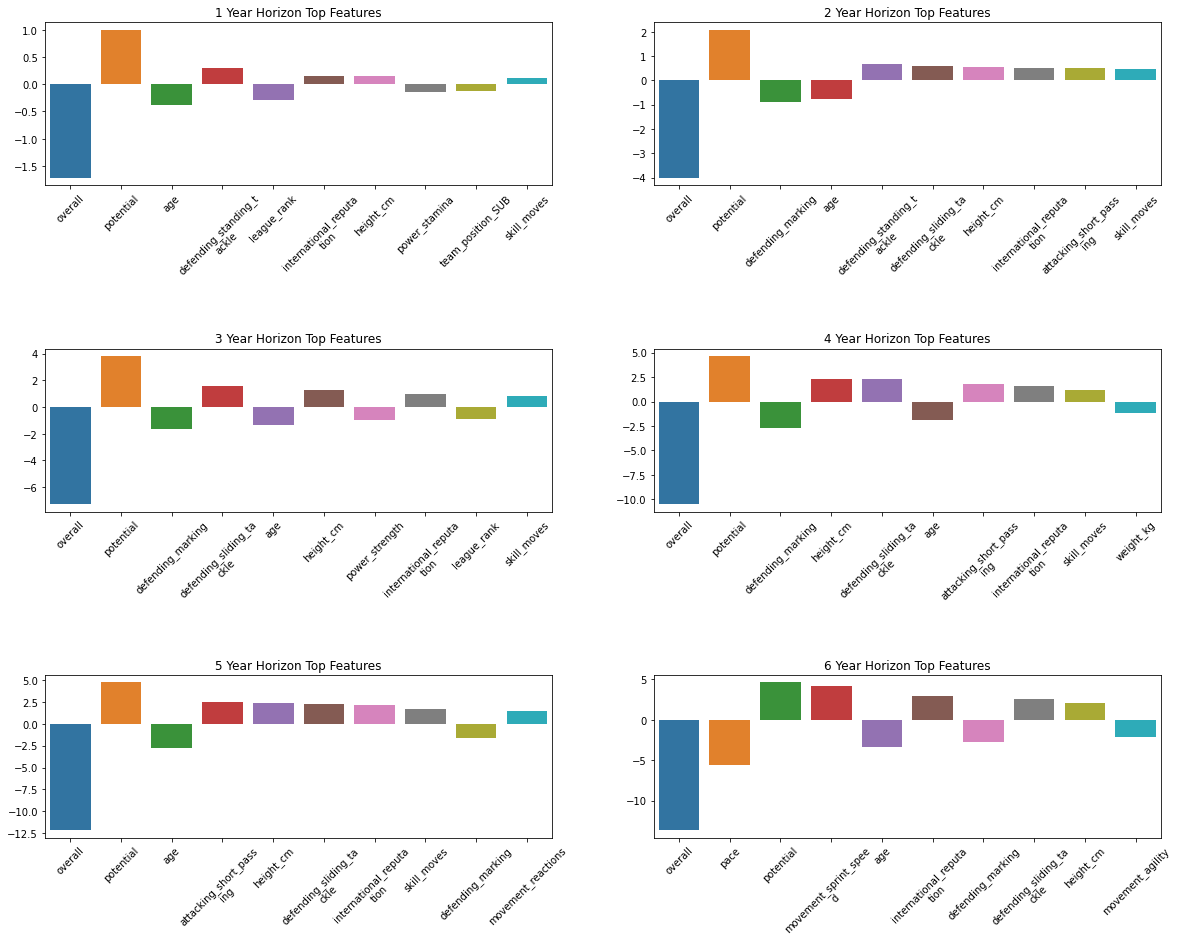

In [59]:
# plot the LASSO coefficients (top 10) for each time horizon
x = [x_scaled_15_16, x_scaled_15_17, x_scaled_15_18, x_scaled_15_19, x_scaled_15_20, x_scaled_15_21]
y = [y_15_16, y_15_17, y_15_18, y_15_19, y_15_20, y_15_21]

horizon_lasso = []
horizon_ridge = []
horizon_scores = []
horizon_models = []
for horizon in range(6):
    horizon_lasso.append(LassoCV(random_state = 42, max_iter = 10000).fit(x[horizon].drop(['sofifa_id'], axis = 1), y[horizon]))
    horizon_ridge.append(RidgeCV().fit(x[horizon].drop(['sofifa_id'], axis = 1), y[horizon]))
    
plt.rcParams["figure.figsize"] = (20,10)
fig, axs = plt.subplots(3, 2, figsize=(20, 15))
fig.subplots_adjust(hspace=1)
axs = axs.ravel()
for i, model in enumerate(horizon_lasso):
    plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=45)
    axs[i].set_title(f'{i+1} Year Horizon Top Features')
    top_10_vars_idx = np.argsort(abs(model.coef_))[::-1][:10]
    # plot the top 10 predictors with the largest magnitude coefficient
    top_vars = col_names[top_10_vars_idx].values
    labels = [ '\n'.join(wrap(l, 20)) for l in top_vars ]
    top_coefs = model.coef_[top_10_vars_idx]
    sns.barplot(labels, top_coefs, ax = axs[i])
    top_10_coef_idx = np.argsort([abs(i) for i in lasso_5.coef_])[-10:]
    top_vars = col_names[top_10_coef_idx]

In [60]:
# results arent very interesting. A player with a high overall is likely to experience a drop in value (overrated)
# a player with a good interational repuatation, leauge_rank, and potential will likely experience value increase
# old players will likely have their value drop in 6 years
# moral of the story: 6 years is a long time and if a player is good currently (high overall), they likely won't be a top 
# star in 6 years

## Random Forest and XGBoost Hyperparameter Tuning

### Random Forest

In [61]:
rf = RandomForestRegressor(random_state = 42, max_depth = 5)
param_grid_rf = {'n_estimators': [30, 50, 100, 150, 300]}
horizon_rf_models, horizon_rf_scores = get_model_results(rf, param_grid_rf, x, y)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

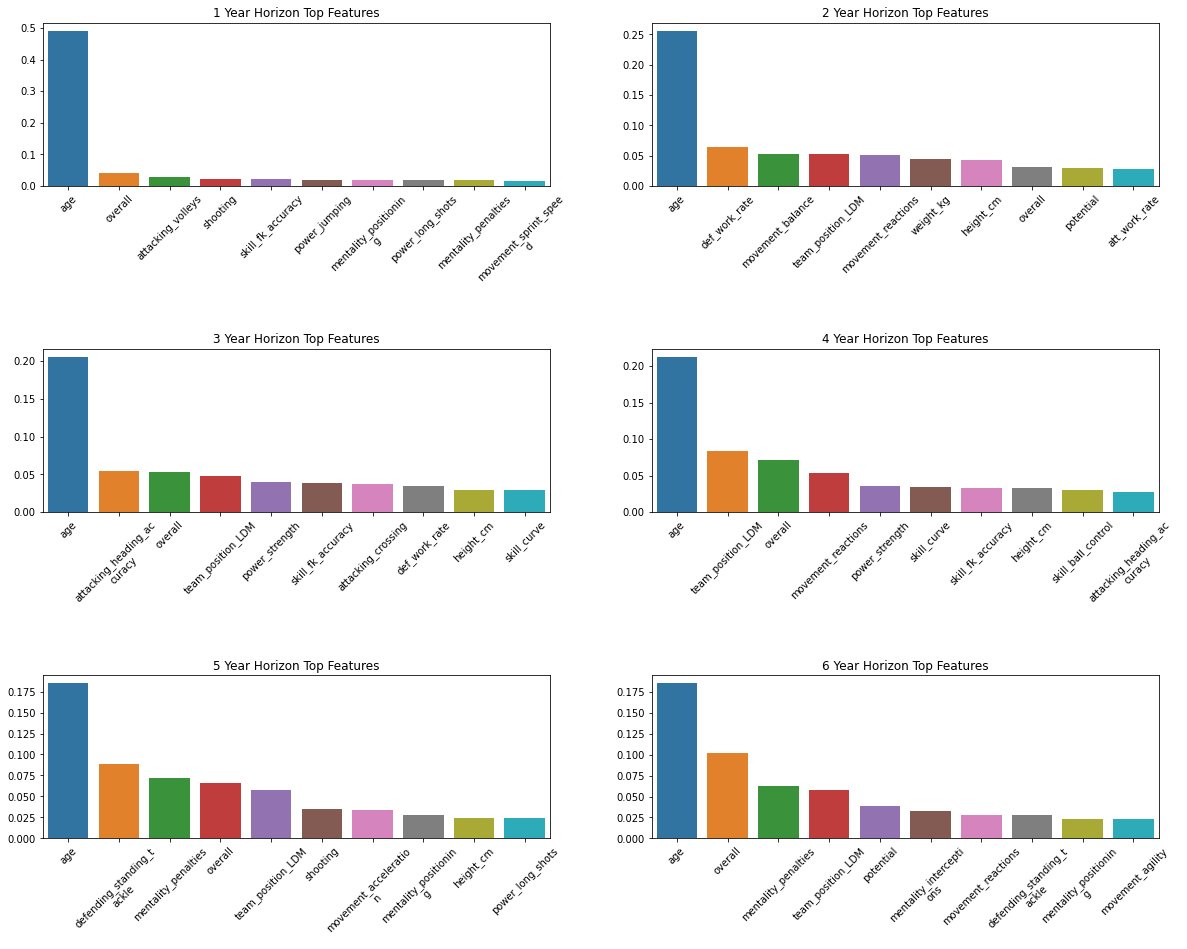

In [62]:
plt.rcParams["figure.figsize"] = (20,10)
fig, axs = plt.subplots(3, 2, figsize=(20, 15))
fig.subplots_adjust(hspace=1)
axs = axs.ravel()
for i, model in enumerate(horizon_rf_models):
    plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=45)
    axs[i].set_title(f'{i+1} Year Horizon Top Features')
    top_10_vars_idx = np.argsort(model.feature_importances_)[::-1][:10]
    # plot the top 10 predictors with the largest magnitude coefficient
    top_vars = col_names[top_10_vars_idx].values
    labels = [ '\n'.join(wrap(l, 20)) for l in top_vars ]
    top_coefs = model.feature_importances_[top_10_vars_idx]
    sns.barplot(labels, top_coefs, ax = axs[i])


Age is the most important feature for all time horizons, which makes sense as this is a universal factor that affects every player's value. A player past their prime will see their value drop and a player entering their prime physical abilitiy age range will see their value increase.

### XGBoost

In [63]:
xgb = XGBRegressor(random_state = 42, objective = 'reg:squarederror')
param_grid_xgb = {'n_estimators': [30, 50, 100, 150, 300], 'learning_rate':[0.05, 0.1, 0.2, 0.3]}
horizon_xgb_models, horizon_xgb_scores = get_model_results(xgb, param_grid_xgb, x, y)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

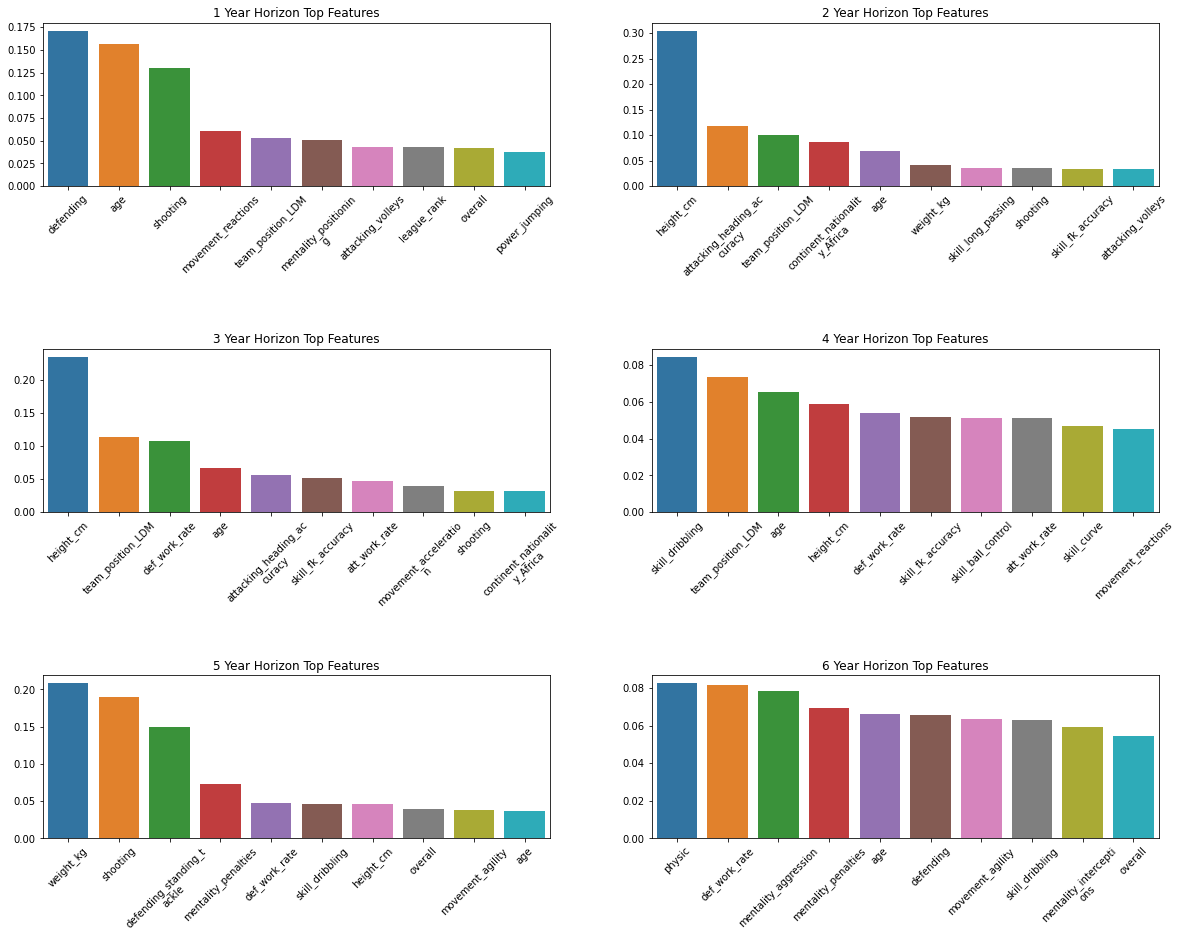

In [64]:
fig, axs = plt.subplots(3, 2, figsize=(20, 15))
fig.subplots_adjust(hspace=1)
axs = axs.ravel()
for i, model in enumerate(horizon_xgb_models):
    plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=45)
    axs[i].set_title(f'{i+1} Year Horizon Top Features')
    top_10_vars_idx = np.argsort(model.feature_importances_)[::-1][:10]
    # plot the top 10 predictors with the largest magnitude coefficient
    top_vars = col_names[top_10_vars_idx].values
    labels = [ '\n'.join(wrap(l, 20)) for l in top_vars ]
    top_coefs = model.feature_importances_[top_10_vars_idx]
    sns.barplot(labels, top_coefs, ax = axs[i])

### Random Forest and XGBoost Using PCA Reduced Dimensionality Components

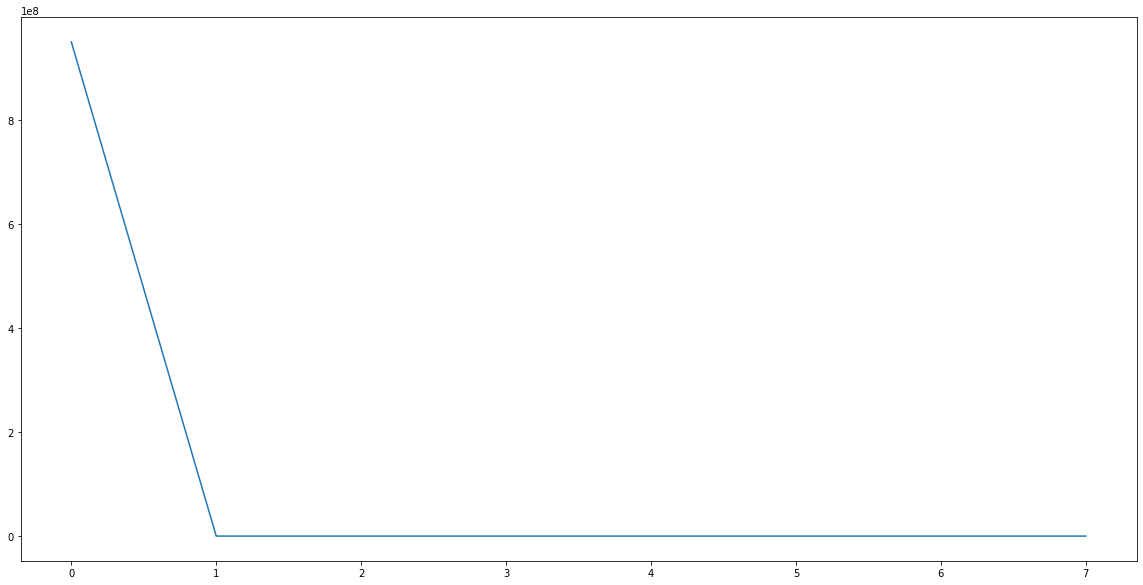

In [67]:
# explained_variance = []
# for i in range(len(x_scaled_15_18.columns)):
#     pca = PCA(n_components = n)
#     explained_variance.append()

pca = PCA(8).fit(x_scaled_15_18, y_15_18)
plt.plot(np.arange(8), pca.explained_variance_)

In [68]:
pca.explained_variance_

array([9.50256509e+08, 1.55035991e+01, 7.57184960e+00, 4.15125643e+00,
       2.67923355e+00, 2.26304824e+00, 1.88876049e+00, 1.58862446e+00])

In [69]:
X_train, X_test, y_train, y_test = train_test_split(x_scaled_15_18.drop(['sofifa_id'], axis = 1), y_15_18, test_size=0.2, random_state=42)
pca_data = pca.fit_transform(X_train)
model = rf.fit(pca_data, y_train)
preds = model.predict(pca.transform(X_test))
mean_absolute_error(y_test, preds)

5.568352369890985

In [70]:
x = [x_scaled_15_16, x_scaled_15_17, x_scaled_15_18, x_scaled_15_19, x_scaled_15_20, x_scaled_15_21]
y = [y_15_16, y_15_17, y_15_18, y_15_19, y_15_20, y_15_21]


In [71]:
rf = RandomForestRegressor(random_state = 42, max_depth = 5)
param_grid_rf = {'n_estimators': [30, 50, 100, 150, 300]}
horizon_rf_pca_models, horizon_rf_pca_scores = get_model_results_pca(rf, param_grid_rf, x, y)

In [72]:
xgb = XGBRegressor(random_state = 42, objective = 'reg:squarederror')
param_grid_xgb = {'n_estimators': [30, 50, 100, 150, 300], 'learning_rate':[0.05, 0.1, 0.2, 0.3]}
horizon_xgb_pca_models, horizon_xgb_pca_scores = get_model_results_pca(xgb, param_grid_xgb, x, y)

### Random Forest and XGBoost Using the LASSO Selected Variables

In [73]:
rf = RandomForestRegressor(random_state = 42, max_depth = 5)
param_grid_rf = {'n_estimators': [30, 50, 100, 150, 300]}
horizon_rf_lasso_models, horizon_rf_lasso_scores = get_model_results_lasso(rf, param_grid_rf, x, y)

In [74]:
xgb = XGBRegressor(random_state = 42, objective = 'reg:squarederror')
param_grid_xgb = {'n_estimators': [30, 50, 100, 150, 300], 'learning_rate':[0.05, 0.1, 0.2, 0.3]}
horizon_xgb_lasso_models, horizon_xgb_lasso_scores = get_model_results_lasso(xgb, param_grid_xgb, x, y)

## Final Performance Evaluation

In [75]:
x = [x_scaled_15_16, x_scaled_15_17, x_scaled_15_18, x_scaled_15_19, x_scaled_15_20, x_scaled_15_21]
y = [y_15_16, y_15_17, y_15_18, y_15_19, y_15_20, y_15_21]

models_dict = {'LASSO':horizon_lasso, 
               'Ridge': horizon_ridge, 
               'Random Forest': horizon_rf_models, 
               'XGBoost': horizon_xgb_models, 
               'Random Forest (PCA)': horizon_rf_pca_models,
               'XGBoost (PCA)':horizon_xgb_pca_models,
               'Random Forest (LASSO Feature Selection)':horizon_rf_lasso_models,
               'XGBoost (LASSO Feature Selection)': horizon_xgb_lasso_models}

In [76]:
# different results table for each horizon
# each table has models as the cols and then the metrics as the rows

models_horizon_1 = [v[0] for k, v in models_dict.items()]
metrics_horizon_1 = [get_performance_metrics(i, x[0], y[0]) for i in models_horizon_1]
metrics_horizon_1

[{'Mean_Absolute_Error': 1.514397629267107,
  'R_Squared': -0.11556037418373333,
  'Root_Mean_Squared_Error': 2.8734539314651206},
 {'Mean_Absolute_Error': 1.3072338522167104,
  'R_Squared': 0.08891320016659392,
  'Root_Mean_Squared_Error': 2.6348407322479717},
 {'Mean_Absolute_Error': 1.8003963648294175,
  'R_Squared': -7.769468578392724,
  'Root_Mean_Squared_Error': 3.907639651635801},
 {'Mean_Absolute_Error': 1.2270219468786157,
  'R_Squared': -0.09122454137465168,
  'Root_Mean_Squared_Error': 2.76987939707693},
 {'Mean_Absolute_Error': 1.8003963648294175,
  'R_Squared': -7.769468578392724,
  'Root_Mean_Squared_Error': 3.907639651635801},
 {'Mean_Absolute_Error': 1.2270219468786157,
  'R_Squared': -0.09122454137465168,
  'Root_Mean_Squared_Error': 2.76987939707693},
 {'Mean_Absolute_Error': 1.844584954941158,
  'R_Squared': -9.00980569366694,
  'Root_Mean_Squared_Error': 4.014457990635255},
 {'Mean_Absolute_Error': 1.2270219468786157,
  'R_Squared': -0.09122454137465168,
  'Root_Mea

In [77]:
horizon_1_final = {'Model': models_dict.keys(), 'Mean_Absolute_Error': [], 'R_Squared': [], "Root_Mean_Squared_Error": []}
for metrics_dict in metrics_horizon_1:
    horizon_1_final['Mean_Absolute_Error'].append(round(metrics_dict['Mean_Absolute_Error'], 2))
    horizon_1_final['R_Squared'].append(round(metrics_dict['R_Squared'], 2))
    horizon_1_final['Root_Mean_Squared_Error'].append(round(metrics_dict['Root_Mean_Squared_Error'], 2))
print("Cross Validated Performance Metrics for Predicting Player Value Growth from 2015-2016")
print('')
pd.DataFrame(horizon_1_final)

Cross Validated Performance Metrics for Predicting Player Value Growth from 2015-2016



,Model,Mean_Absolute_Error,R_Squared,Root_Mean_Squared_Error
0,LASSO,1.51,-0.12,2.87
1,Ridge,1.31,0.09,2.63
2,Random Forest,1.80,-7.77,3.91
3,XGBoost,1.23,-0.09,2.77
4,Random Forest (PCA),1.80,-7.77,3.91
5,XGBoost (PCA),1.23,-0.09,2.77
6,Random Forest (LASSO Feature Selection),1.84,-9.01,4.01
7,XGBoost (LASSO Feature Selection),1.23,-0.09,2.77


In [78]:
models_horizon_2 = [v[1] for k, v in models_dict.items()]
metrics_horizon_2 = [get_performance_metrics(i, x[1], y[1]) for i in models_horizon_2]

horizon_2_final = {'Model': models_dict.keys(), 'Mean_Absolute_Error': [], 'R_Squared': [], "Root_Mean_Squared_Error": []}
for metrics_dict in metrics_horizon_2:
    horizon_2_final['Mean_Absolute_Error'].append(round(metrics_dict['Mean_Absolute_Error'], 2))
    horizon_2_final['R_Squared'].append(round(metrics_dict['R_Squared'], 2))
    horizon_2_final['Root_Mean_Squared_Error'].append(round(metrics_dict['Root_Mean_Squared_Error'], 2))
print("Cross Validated Performance Metrics for Predicting Player Value Growth from 2015-2017")
print('')
pd.DataFrame(horizon_2_final)

Cross Validated Performance Metrics for Predicting Player Value Growth from 2015-2017



,Model,Mean_Absolute_Error,R_Squared,Root_Mean_Squared_Error
0,LASSO,3.29,-0.51,7.10
1,Ridge,2.96,-0.12,6.61
2,Random Forest,2.80,-0.15,6.91
3,XGBoost,2.52,0.08,6.62
4,Random Forest (PCA),2.80,-0.15,6.91
5,XGBoost (PCA),2.52,0.08,6.62
6,Random Forest (LASSO Feature Selection),2.80,-0.15,6.91
7,XGBoost (LASSO Feature Selection),2.52,0.08,6.62


In [79]:
models_horizon_3 = [v[2] for k, v in models_dict.items()]
metrics_horizon_3 = [get_performance_metrics(i, x[2], y[2]) for i in models_horizon_3]

horizon_3_final = {'Model': models_dict.keys(), 'Mean_Absolute_Error': [], 'R_Squared': [], "Root_Mean_Squared_Error": []}
for metrics_dict in metrics_horizon_3:
    horizon_3_final['Mean_Absolute_Error'].append(round(metrics_dict['Mean_Absolute_Error'], 2))
    horizon_3_final['R_Squared'].append(round(metrics_dict['R_Squared'], 2))
    horizon_3_final['Root_Mean_Squared_Error'].append(round(metrics_dict['Root_Mean_Squared_Error'], 2))
print("Cross Validated Performance Metrics for Predicting Player Value Growth from 2015-2018")
print('')
pd.DataFrame(horizon_3_final)

Cross Validated Performance Metrics for Predicting Player Value Growth from 2015-2018



,Model,Mean_Absolute_Error,R_Squared,Root_Mean_Squared_Error
0,LASSO,6.18,-1.00,13.38
1,Ridge,5.75,-0.28,12.49
2,Random Forest,5.32,-0.20,12.89
3,XGBoost,4.82,0.05,12.64
4,Random Forest (PCA),5.33,-0.20,12.86
5,XGBoost (PCA),4.82,0.05,12.64
6,Random Forest (LASSO Feature Selection),5.36,-0.25,13.11
7,XGBoost (LASSO Feature Selection),4.82,0.05,12.64


In [80]:
models_horizon_4 = [v[3] for k, v in models_dict.items()]
metrics_horizon_4 = [get_performance_metrics(i, x[3], y[3]) for i in models_horizon_4]

horizon_4_final = {'Model': models_dict.keys(), 'Mean_Absolute_Error': [], 'R_Squared': [], "Root_Mean_Squared_Error": []}
for metrics_dict in metrics_horizon_4:
    horizon_4_final['Mean_Absolute_Error'].append(round(metrics_dict['Mean_Absolute_Error'], 2))
    horizon_4_final['R_Squared'].append(round(metrics_dict['R_Squared'], 2))
    horizon_4_final['Root_Mean_Squared_Error'].append(round(metrics_dict['Root_Mean_Squared_Error'], 2))
print("Cross Validated Performance Metrics for Predicting Player Value Growth from 2015-2019")
print('')
pd.DataFrame(horizon_4_final)

Cross Validated Performance Metrics for Predicting Player Value Growth from 2015-2019



,Model,Mean_Absolute_Error,R_Squared,Root_Mean_Squared_Error
0,LASSO,8.27,-1.31,17.66
1,Ridge,7.78,-0.55,16.48
2,Random Forest,6.97,-0.37,16.79
3,XGBoost,6.16,0.04,15.90
4,Random Forest (PCA),6.92,-0.41,16.71
5,XGBoost (PCA),6.16,0.04,15.90
6,Random Forest (LASSO Feature Selection),6.92,-0.41,16.71
7,XGBoost (LASSO Feature Selection),6.16,0.04,15.90


In [81]:
models_horizon_5 = [v[4] for k, v in models_dict.items()]
metrics_horizon_5 = [get_performance_metrics(i, x[4], y[4]) for i in models_horizon_5]

horizon_5_final = {'Model': models_dict.keys(), 'Mean_Absolute_Error': [], 'R_Squared': [], "Root_Mean_Squared_Error": []}
for metrics_dict in metrics_horizon_5:
    horizon_5_final['Mean_Absolute_Error'].append(round(metrics_dict['Mean_Absolute_Error'], 2))
    horizon_5_final['R_Squared'].append(round(metrics_dict['R_Squared'], 2))
    horizon_5_final['Root_Mean_Squared_Error'].append(round(metrics_dict['Root_Mean_Squared_Error'], 2))
print("Cross Validated Performance Metrics for Predicting Player Value Growth from 2015-2020")
print('')
pd.DataFrame(horizon_5_final)

Cross Validated Performance Metrics for Predicting Player Value Growth from 2015-2020



,Model,Mean_Absolute_Error,R_Squared,Root_Mean_Squared_Error
0,LASSO,10.57,-1.62,22.29
1,Ridge,9.93,-0.92,20.92
2,Random Forest,8.79,-0.25,20.52
3,XGBoost,7.74,0.04,19.90
4,Random Forest (PCA),8.79,-0.25,20.52
5,XGBoost (PCA),7.74,0.04,19.90
6,Random Forest (LASSO Feature Selection),8.79,-0.25,20.52
7,XGBoost (LASSO Feature Selection),7.74,0.04,19.90


In [82]:
models_horizon_6 = [v[5] for k, v in models_dict.items()]
metrics_horizon_6 = [get_performance_metrics(i, x[5], y[5]) for i in models_horizon_6]

horizon_6_final = {'Model': models_dict.keys(), 'Mean_Absolute_Error': [], 'R_Squared': [], "Root_Mean_Squared_Error": []}
for metrics_dict in metrics_horizon_6:
    horizon_6_final['Mean_Absolute_Error'].append(round(metrics_dict['Mean_Absolute_Error'], 2))
    horizon_6_final['R_Squared'].append(round(metrics_dict['R_Squared'], 2))
    horizon_6_final['Root_Mean_Squared_Error'].append(round(metrics_dict['Root_Mean_Squared_Error'], 2))
print("Cross Validated Performance Metrics for Predicting Player Value Growth from 2015-2021")
print('')
pd.DataFrame(horizon_6_final)

Cross Validated Performance Metrics for Predicting Player Value Growth from 2015-2021



,Model,Mean_Absolute_Error,R_Squared,Root_Mean_Squared_Error
0,LASSO,11.67,-2.66,23.35
1,Ridge,11.21,-1.59,21.92
2,Random Forest,9.79,-0.22,20.44
3,XGBoost,8.50,0.04,20.02
4,Random Forest (PCA),9.80,-0.27,20.67
5,XGBoost (PCA),8.50,0.04,20.02
6,Random Forest (LASSO Feature Selection),9.79,-0.22,20.44
7,XGBoost (LASSO Feature Selection),8.50,0.04,20.02


## Final Model Fitting on Entire Dataset for Each Horizon (Best Model)

In [83]:
x = [x_scaled_15_16, x_scaled_15_17, x_scaled_15_18, x_scaled_15_19, x_scaled_15_20, x_scaled_15_21]
y = [y_15_16, y_15_17, y_15_18, y_15_19, y_15_20, y_15_21]

# horizon 1: xgboost base - best MAE and still good RMSE
horizon_1_model = horizon_xgb_models[0].fit(x[0].drop(['sofifa_id'], axis = 1), y[0])

# horizon 2: xgboost base - best MAE and RMSE and R2
horizon_2_model = horizon_xgb_models[1].fit(x[1].drop(['sofifa_id'], axis = 1), y[1])
# horizon 3: xgboost base - best MAE and R2, RMSE close
horizon_3_model = horizon_xgb_models[2].fit(x[2].drop(['sofifa_id'], axis = 1), y[2])
# horizon 4: xgboost base - best MAE and RMSE and R2
horizon_4_model = horizon_xgb_models[3].fit(x[3].drop(['sofifa_id'], axis = 1), y[3])
# horizon 5: xgboost base - best MAE and RMSE and R2
horizon_5_model = horizon_xgb_models[4].fit(x[4].drop(['sofifa_id'], axis = 1), y[4])
# horizon 6: xgboost base - best MAE and RMSE and R2
horizon_6_model = horizon_xgb_models[5].fit(x[5].drop(['sofifa_id'], axis = 1), y[5])
# observations: the error increases as the horizon gets farther out (which makes sense, more uncertainty)

## Final Prediction for Each Horizon (Using Best Model)

In [84]:
horizon_xgb_models

[XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              importance_type='gain', learning_rate=0.05, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=30,
              n_jobs=1, nthread=None, objective='reg:squarederror',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1),
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              importance_type='gain', learning_rate=0.05, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=30,
              n_jobs=1, nthread=None, objective='reg:squarederror',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1),
 XGBRe

In [87]:
# 2021 data_prep
x_clean_2021, cols = data_cleaning_test(fifa_21, False)
player_lookup_map_2021 = {game_id: name for (game_id, name) in zip(fifa_21.sofifa_id, fifa_21.long_name)}

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


In [88]:
# Picks for 2022 Potential
value_pred_2022 = horizon_1_model.predict(x_clean_2021.drop(['sofifa_id'], axis = 1))

# top potential players in test set predicted
top_10_preds = np.argsort(value_pred_2022)[::-1][:10]

top_10_ids = x_clean_2021.iloc[top_10_preds, :]['sofifa_id'].values
print('predicted top 10 highest growth players 2022')
print('')
pred_best_2022 = set([player_lookup_map_2021[i] for i in top_10_ids])
pred_best_2022

predicted top 10 highest growth players 2022



{'Dannie Bulman',
 'Hussein Omar Abdul Ghani Sulaimani',
 'Jay Barnett',
 'Juan Francisco Martínez Modesto',
 'Júlio César Cáceres López',
 'Nikolaos Baxevanos',
 'Paulo César Da Silva Barrios',
 'Vitorino Hilton da Silva',
 '远藤 保仁',
 '이동국 李东国'}

In [89]:
# Picks for 2023 Potential
value_pred_2023 = horizon_2_model.predict(x_clean_2021.drop(['sofifa_id'], axis = 1))

# top potential players in test set predicted
top_10_preds = np.argsort(value_pred_2023)[::-1][:10]

top_10_ids = x_clean_2021.iloc[top_10_preds, :]['sofifa_id'].values
print('predicted top 10 highest growth players 2023')
print('')
pred_best_2023 = set([player_lookup_map_2021[i] for i in top_10_ids])
pred_best_2023

predicted top 10 highest growth players 2023



{'Díver Jesús Torres Ferrer',
 'Gonzalo Gabriel Sánchez Franco',
 'Kevin Raphael Diaz',
 'Mark Marleku',
 'Shpetim Sulejmani',
 'Wassim Aouachria',
 'Yiming Yang',
 'Ziming Liu',
 '冯伯元',
 '张元'}

In [90]:
# Picks for 2024 Potential
value_pred_2024 = horizon_3_model.predict(x_clean_2021.drop(['sofifa_id'], axis = 1))

# top potential players in test set predicted
top_10_preds = np.argsort(value_pred_2024)[::-1][:10]

top_10_ids = x_clean_2021.iloc[top_10_preds, :]['sofifa_id'].values
print('predicted top 10 highest growth players 2024')
print('')
pred_best_2024 = set([player_lookup_map_2021[i] for i in top_10_ids])
pred_best_2024

predicted top 10 highest growth players 2024



{'Díver Jesús Torres Ferrer',
 'Ibrahim Bakare',
 'Ionuţ Radu Mitran',
 'Jarrad Branthwaite',
 'Jean Emile Junior Onana Onana',
 'Joe Woodiwiss',
 'Kyle Hayde',
 'Mohamed Traore',
 'Uniss Kargbo',
 'Yu Zhang'}

In [91]:
# Picks for 2025 Potential
value_pred_2025 = horizon_4_model.predict(x_clean_2021.drop(['sofifa_id'], axis = 1))

# top potential players in test set predicted
top_10_preds = np.argsort(value_pred_2025)[::-1][:10]

top_10_ids = x_clean_2021.iloc[top_10_preds, :]['sofifa_id'].values
print('predicted top 10 highest growth players 2025')
print('')
pred_best_2025 = set([player_lookup_map_2021[i] for i in top_10_ids])
pred_best_2025

predicted top 10 highest growth players 2025



{'Alfie Bates',
 'Christopher Merrie',
 'Díver Jesús Torres Ferrer',
 'Harvey Saunders',
 'Isaac Hutchinson',
 'James Akintunde',
 'Jay Barnett',
 'Manuel Ugarte Ribeiro',
 'Mohamed Traore',
 '高大伦'}

In [92]:
# Picks for 2026 Potential
value_pred_2026 = horizon_5_model.predict(x_clean_2021.drop(['sofifa_id'], axis = 1))

# top potential players in test set predicted
top_10_preds = np.argsort(value_pred_2026)[::-1][:10]

top_10_ids = x_clean_2021.iloc[top_10_preds, :]['sofifa_id'].values
print('predicted top 10 highest growth players 2026')
print('')
pred_best_2026 = set([player_lookup_map_2021[i] for i in top_10_ids])
pred_best_2026

predicted top 10 highest growth players 2026



{'Adelin Valentin Voinescu',
 'Christian Marcelo Silva de León',
 'Diego Ferney Abadía García',
 'Ged Garner',
 'Harvey Saunders',
 'Jamie Browne',
 'Jiaxing Deng',
 'Luis Robles',
 'Memet Abdulla Ezmat',
 'Nicolás Daniel Ruiz Tabárez'}

In [93]:
# Picks for 2027 Potential
value_pred_2027 = horizon_6_model.predict(x_clean_2021.drop(['sofifa_id'], axis = 1))

# top potential players in test set predicted
top_10_preds = np.argsort(value_pred_2027)[::-1][:10]

top_10_ids = x_clean_2021.iloc[top_10_preds, :]['sofifa_id'].values
print('predicted top 10 highest growth players 2027')
print('')
pred_best_2027 = set([player_lookup_map_2021[i] for i in top_10_ids])
pred_best_2027

predicted top 10 highest growth players 2027



{'Adrián Alejandro Mejía Carrasco',
 'Bruno Scorza Perdomo',
 'Edgaras Dubickas',
 'Harvey Saunders',
 'Jamie Browne',
 'Luis Robles',
 'Michael Tait',
 'Ricardo Dinanga',
 'Saúl Alejandro Guarirapa Briceño',
 '懂洪麟'}